In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from src import config
import os
import statsmodels.formula.api as smf
from article.report_utils import (
    retrieve_fs_thick,
    get_cortical_rubic_df,
    get_cortical_mrart_df,
    fit_one_per_model,
    get_cortical_hcpep_df,
    get_cortical_hcpya_df,
    get_all_openneuro,
    fit_one_per_model_per_dataset_openneuro,
)
from scipy.stats import spearmanr, false_discovery_control

sb.set_theme()

## Synthetic Data

Text(0.5, 0, 'Motion Score')

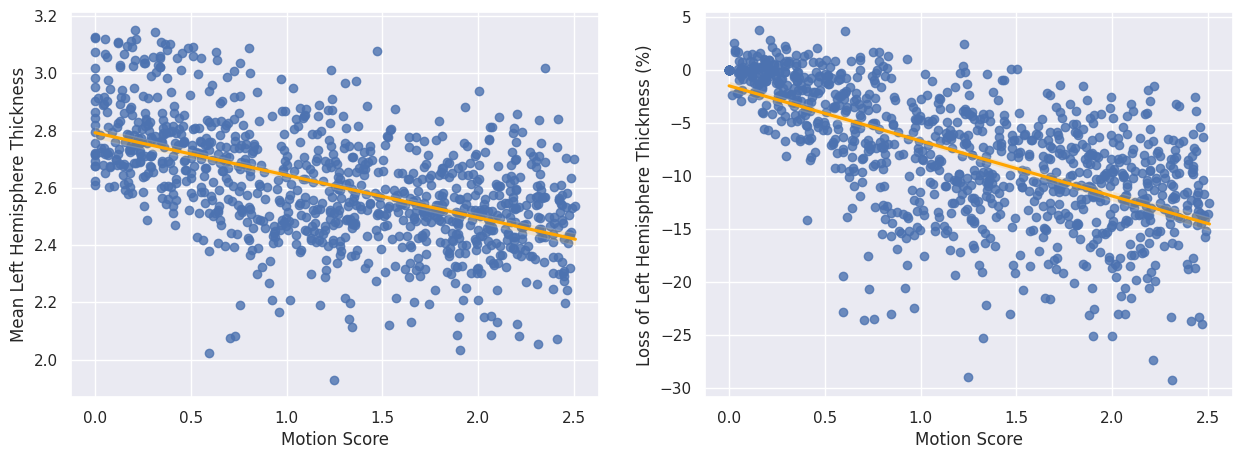

In [5]:
scores = pd.read_csv(
    os.path.join(config.DATASET_ROOT, config.FREESURFER_SYNTH_FOLDER, "scores.csv"),
    index_col=0,
).rename(
    columns={
        "subject": "sub",
        "session": "ses",
    }
)

thick = retrieve_fs_thick("FS_SynthCortical_V2", synthetic=True)
synth_df = scores.merge(thick, on=("sub", "ses", "generation"))
cuny_participants = pd.read_csv(
    "article/participants_csv/HBN_CUNY_participants.tsv", sep="\t"
)
cbic_participants = pd.read_csv(
    "article/participants_csv/HBN_CBIC_participants.tsv", sep="\t"
)
participants = pd.concat([cuny_participants, cbic_participants]).rename(
    columns={"participant_id": "sub", "Age": "age", "Sex": "sex"}
)
synth_df = synth_df.merge(participants, on="sub")
for sub in synth_df["sub"].unique():
    sub_df = synth_df[synth_df["sub"] == sub]
    for ses in sub_df["ses"].unique():
        ses_df = sub_df[sub_df["ses"] == ses]
        orig = ses_df[ses_df["generation"] == "gen-orig"]["lh_thickness"].item()
        synth_df.loc[
            (synth_df["sub"] == sub) & (synth_df["ses"] == ses), "orig_lh_thick"
        ] = orig
synth_df["loss_lh_percent"] = (
    (synth_df["lh_thickness"] - synth_df["orig_lh_thick"])
    / synth_df["orig_lh_thick"]
    * 100
)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sb.regplot(
    synth_df,
    x="motion_mm",
    y="lh_thickness",
    line_kws={"color": "orange"},
)
plt.xlabel("Motion Score")
plt.ylabel("Mean Left Hemisphere Thickness")
plt.subplot(1, 2, 2)
sb.regplot(
    synth_df,
    x="motion_mm",
    y="loss_lh_percent",
    line_kws={"color": "orange"},
)
plt.ylabel("Loss of Left Hemisphere Thickness (%)")

plt.xlabel("Motion Score")

In [6]:
est = smf.glm(data=synth_df, formula="lh_thickness ~ age + sex + motion_mm")
print(est.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           lh_thickness   No. Observations:                  996
Model:                            GLM   Df Residuals:                      992
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                        0.022514
Method:                          IRLS   Log-Likelihood:                 477.96
Date:                Sun, 20 Apr 2025   Deviance:                       22.334
Time:                        11:00:13   Pearson chi2:                     22.3
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5832
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1017      0.027    114.939      0.0

## Test Datasets

In [7]:
models = [
    "SFCN_conv1_noaug_noshift",
    "SFCN_conv2_noaug_noshift",
    "SFCN_conv2_aug_noshift",
    "SFCN_conv2_aug_shift",
]

### Synthetic Test

In [8]:
all = []
for m in models:
    df = pd.read_csv(
        f"article/reports/test_report/synthetic/{m}_report.csv", index_col=0
    )
    df["model"] = m
    all.append(df)
synth_df = pd.concat(all)
synth_df

,model,r2_score,rmse
0,SFCN_conv1_noaug_noshift,0.916844,0.339276
0,SFCN_conv2_noaug_noshift,0.940352,0.287345
0,SFCN_conv2_aug_noshift,0.921229,0.330210
0,SFCN_conv2_aug_shift,0.898289,0.375224


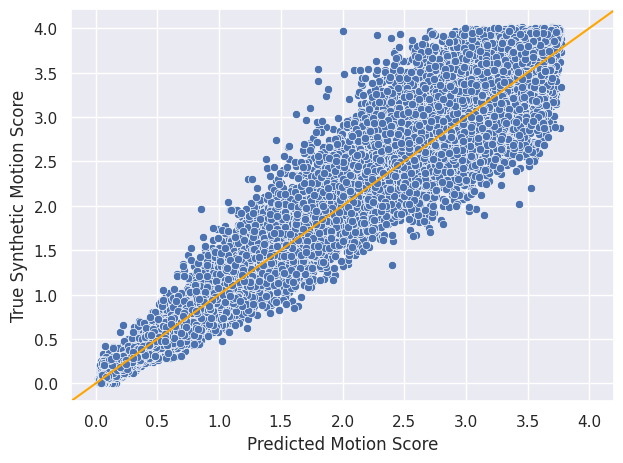

In [9]:
synth_pred_df = pd.read_csv(
    f"article/reports/test_report/synthetic/{models[1]}_pred.csv", index_col=0
)
synth_pred_df["motion"] = synth_pred_df["motion"].apply(
    lambda x: float(x.removeprefix("tensor(").removesuffix(", dtype=torch.float64)"))
)
synth_pred_df["label"] = synth_pred_df["label"].apply(
    lambda x: float(x.removeprefix("tensor(").removesuffix(", dtype=torch.float64)"))
)
synth_pred_df["model"] = "SFCN_conv2_aug_shift"
all.append(df)
sb.scatterplot(synth_pred_df, x="motion", y="label")
plt.axline((0, 0), (4, 4), c="orange", clip_on=True)
plt.xlabel("Predicted Motion Score")
plt.ylabel("True Synthetic Motion Score")
plt.tight_layout()
plt.savefig("article/figures/calibration_sfcn2_base")

### HBNRU

/opt/anaconda/envs/bowl/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/anaconda/envs/bowl/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


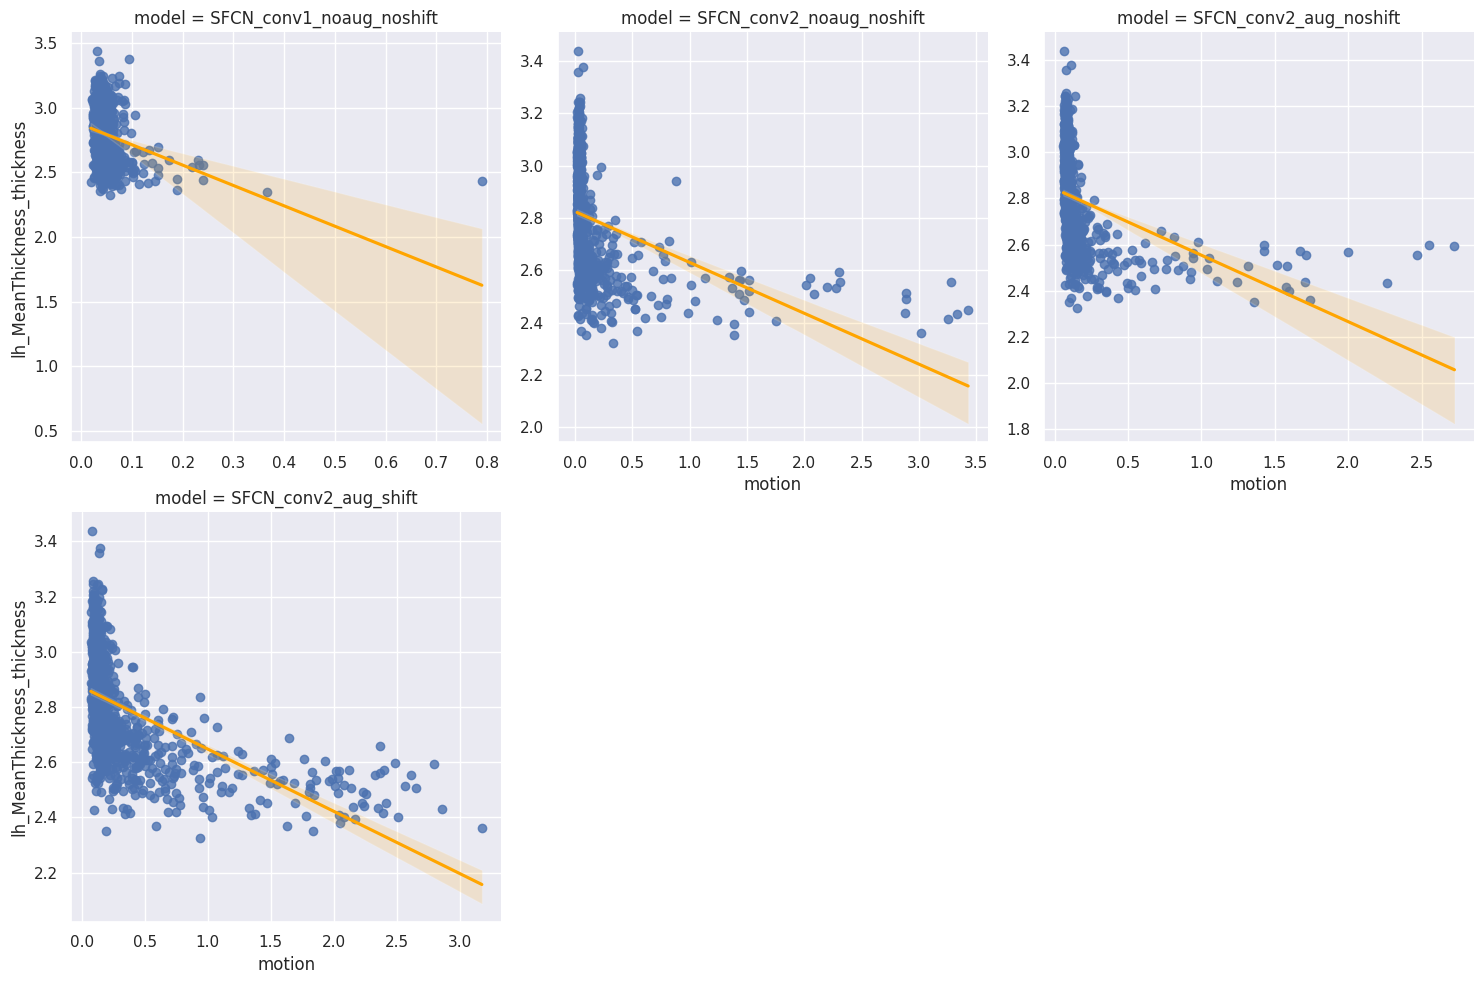

In [10]:
all = []
for m in models:
    all.append(get_cortical_rubic_df(m))
hbnru_df = pd.concat(all)
sb.lmplot(
    hbnru_df,
    x="motion",
    y="lh_MeanThickness_thickness",
    line_kws={"color": "orange"},
    col="model",
    sharex=False,
    col_wrap=3,
    sharey=False,
)

In [11]:
fit_one_per_model(hbnru_df)

,Intercept,age,sex,motion,model,r2,rse,pvalue,log_likelihood,rank
0,3.057778,-0.019316,0.069356,-0.246144,SFCN_conv2_aug_shift,0.554287,0.146382,1.553597e-143,517.167401,1
1,2.993412,-0.016742,0.078748,-0.317439,SFCN_conv2_aug_noshift,0.299611,0.169085,2.246810e-52,369.382418,2
2,2.975179,-0.016695,0.075296,-0.212319,SFCN_conv2_noaug_noshift,0.295260,0.169473,4.009294e-51,367.029752,3
3,3.019693,-0.015969,0.079665,-1.792177,SFCN_conv1_noaug_noshift,0.209119,0.177235,8.771333e-28,321.126122,4


In [14]:
est = smf.glm(
    "motion ~ age ", data=hbnru_df[hbnru_df["model"] == "SFCN_conv2_aug_shift"]
)
estfit = est.fit()
print(estfit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 motion   No. Observations:                 1025
Model:                            GLM   Df Residuals:                     1023
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                         0.22525
Method:                          IRLS   Log-Likelihood:                -689.51
Date:                Sun, 20 Apr 2025   Deviance:                       230.43
Time:                        11:02:35   Pearson chi2:                     230.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.02735
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5693      0.046     12.280      0.0

### MR-ART

/opt/anaconda/envs/bowl/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


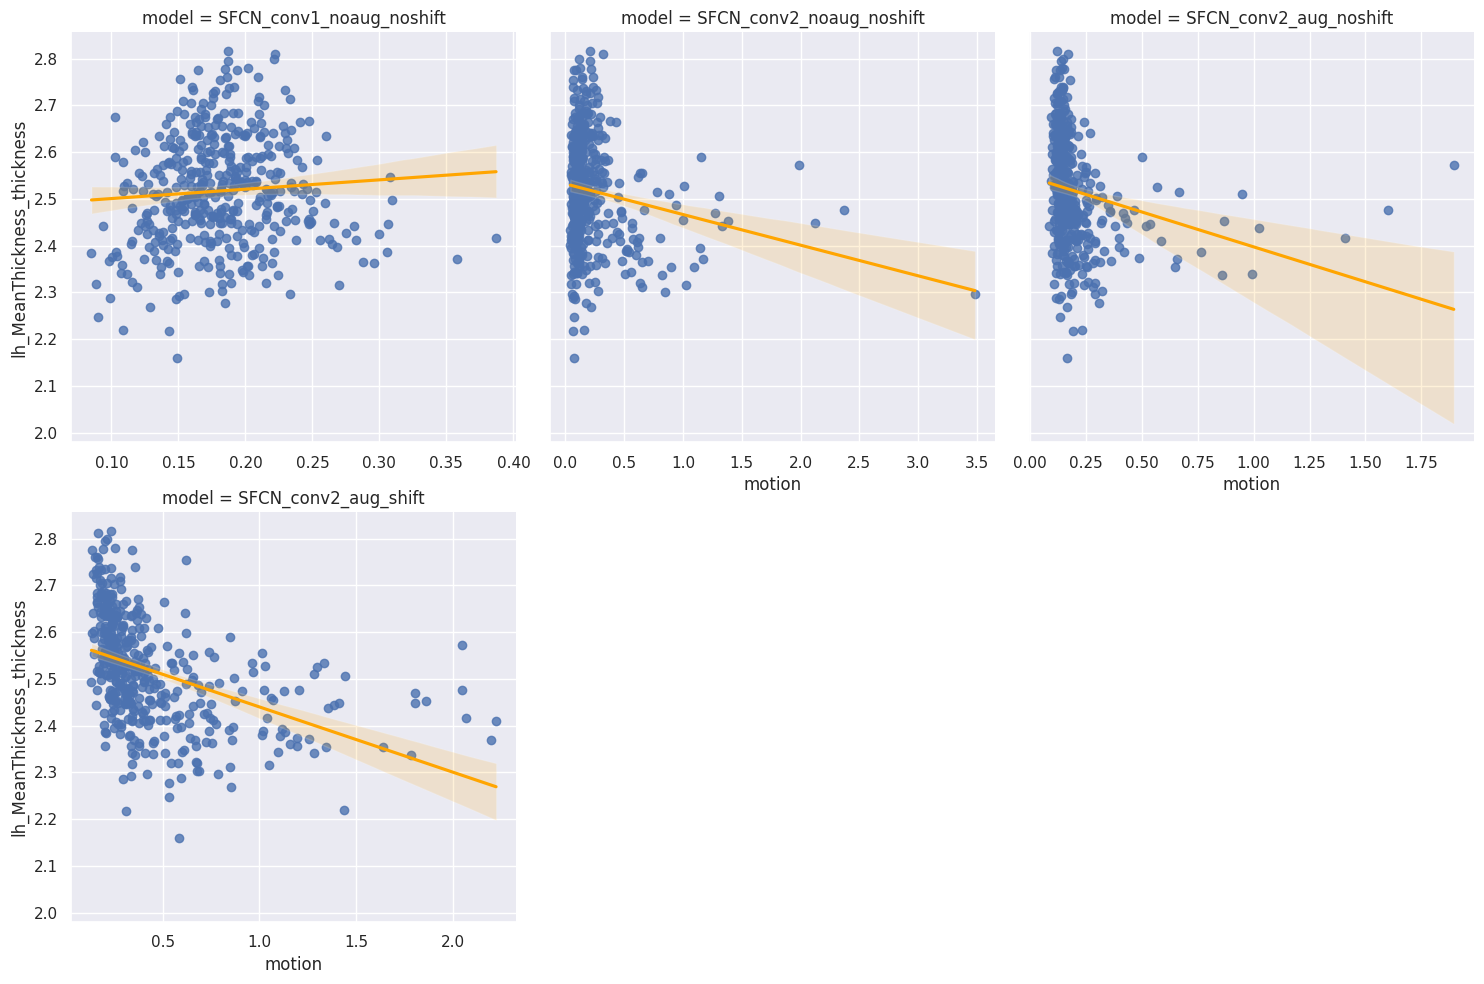

In [15]:
all = []
for m in models:
    all.append(get_cortical_mrart_df(m))
mrart_df = pd.concat(all)
sb.lmplot(
    mrart_df,
    x="motion",
    y="lh_MeanThickness_thickness",
    line_kws={"color": "orange"},
    col="model",
    sharex=False,
    col_wrap=3,
)

In [16]:
fit_one_per_model(mrart_df)

,Intercept,sex[T.M],age,motion,model,r2,rse,pvalue,log_likelihood,rank
0,2.674630,-0.058721,-0.002750,-0.124251,SFCN_conv2_aug_shift,0.386158,0.095687,1.188194e-21,404.646129,1
1,2.659209,-0.061476,-0.003132,-0.138659,SFCN_conv2_aug_noshift,0.254745,0.102657,1.637097e-06,374.130825,2
2,2.646945,-0.061043,-0.003177,-0.060899,SFCN_conv2_noaug_noshift,0.237211,0.103599,1.207707e-04,370.167005,3
3,2.605490,-0.056260,-0.003350,0.169396,SFCN_conv1_noaug_noshift,0.208950,0.105126,1.621278e-01,363.817273,4


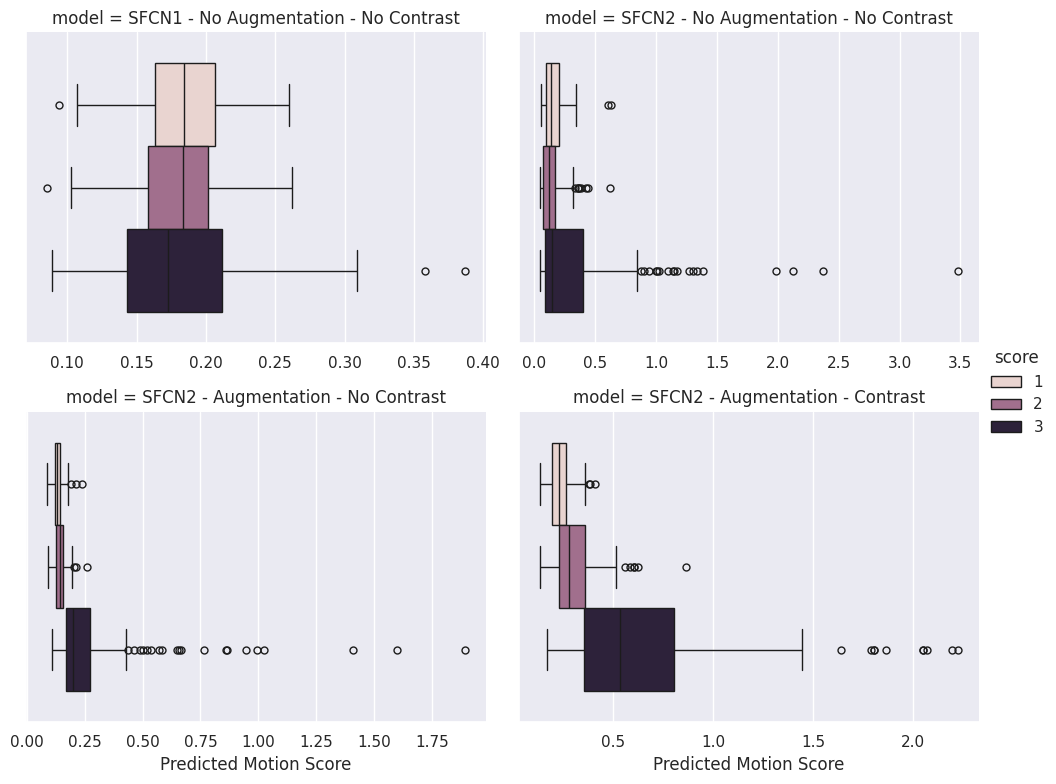

In [17]:
mrart_renamed = mrart_df.copy()
mrart_renamed["model"] = mrart_renamed["model"].apply(
    lambda x: "No ".join(
        x.replace("_conv", "").removesuffix("_noweight").replace("_", " - ").split("no")
    )
    .replace("aug", "Augmentation")
    .replace("shift", "Contrast")
)
mrart_renamed["Predicted Motion Score"] = mrart_renamed["motion"]

sb.catplot(
    mrart_renamed,
    x="Predicted Motion Score",
    hue="score",
    col="model",
    kind="box",
    sharex=False,
    col_wrap=2,
    height=4,
    aspect=1.25,
)
plt.savefig("article/figures/boxplot_mrart")

In [18]:
for m in models:
    m_df = mrart_df[mrart_df["model"] == m]
    rho, p = spearmanr(m_df["motion"], m_df["score"])
    print(m, rho, p)

SFCN_conv1_noaug_noshift -0.10033866335165752 0.03665650395147665
SFCN_conv2_noaug_noshift 0.10683087648316215 0.026045957394502425
SFCN_conv2_aug_noshift 0.6631468787993026 2.565940379223204e-56
SFCN_conv2_aug_shift 0.7089418962096191 1.6636495800779954e-67


In [20]:
est = smf.glm(
    "motion ~ age ", data=mrart_df[mrart_df["model"] == "SFCN_conv2_aug_shift"]
)
estfit = est.fit()
print(estfit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 motion   No. Observations:                  434
Model:                            GLM   Df Residuals:                      432
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                         0.12545
Method:                          IRLS   Log-Likelihood:                -164.36
Date:                Sun, 20 Apr 2025   Deviance:                       54.194
Time:                        11:02:48   Pearson chi2:                     54.2
No. Iterations:                     3   Pseudo R-squ. (CS):            0.02208
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3170      0.044      7.128      0.0

### HCP-YA

/opt/anaconda/envs/bowl/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


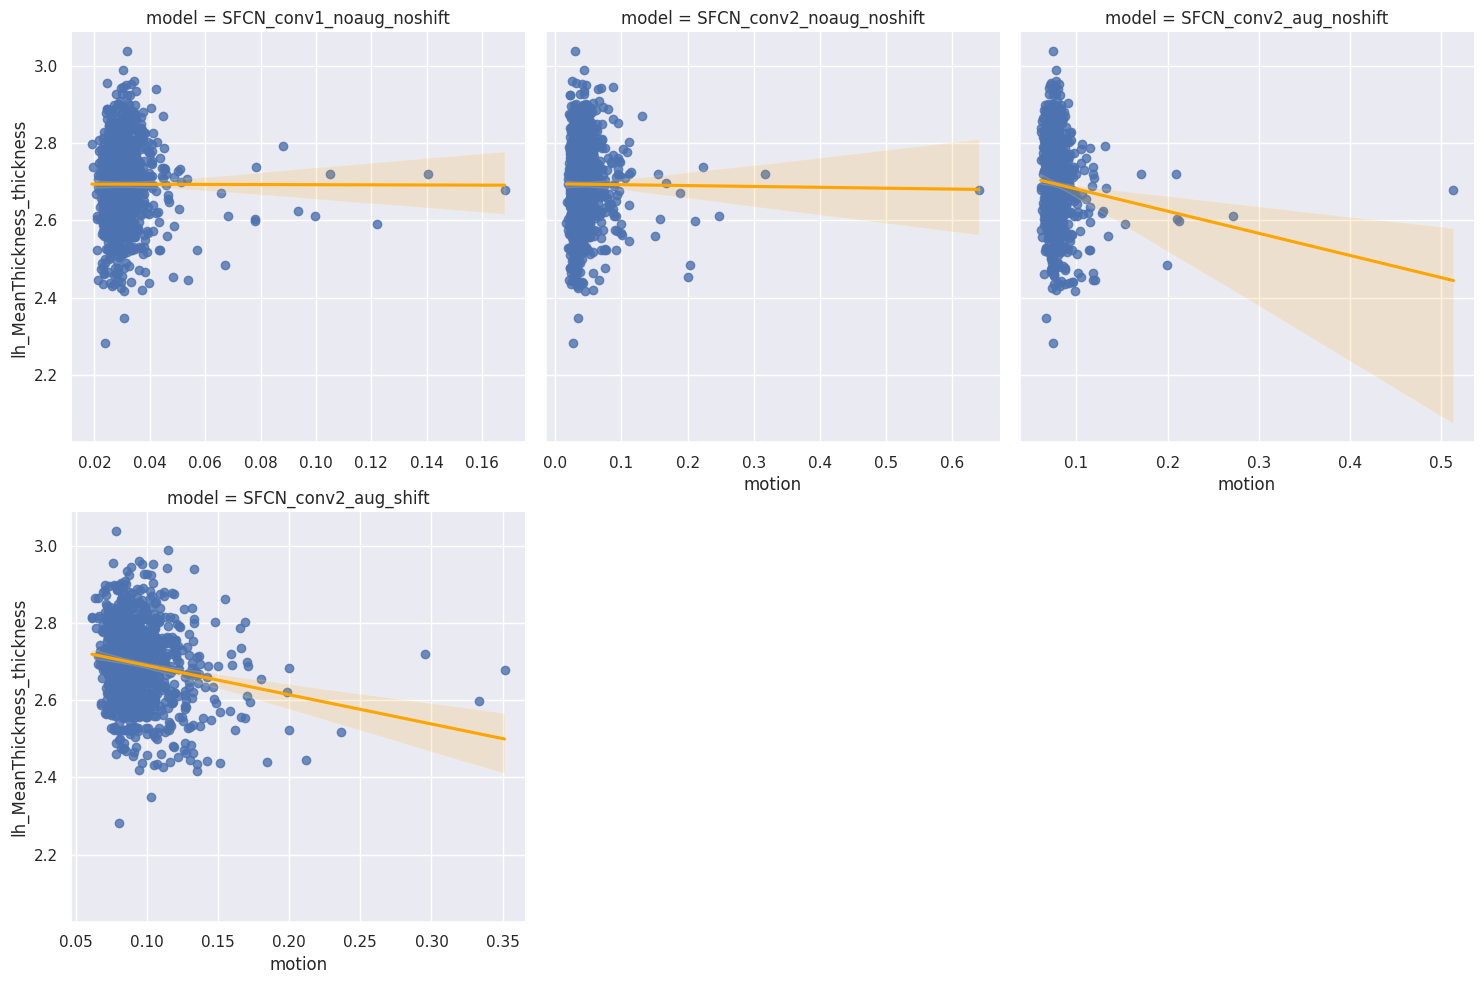

In [21]:
all = []
for m in models:
    all.append(get_cortical_hcpya_df(m))
hcpya_df = pd.concat(all)
sb.lmplot(
    hcpya_df,
    x="motion",
    y="lh_MeanThickness_thickness",
    line_kws={"color": "orange"},
    col="model",
    sharex=False,
    col_wrap=3,
)

In [22]:
fit_one_per_model(hcpya_df)

,Intercept,age[T.26-30],age[T.31-35],age[T.36+],sex[T.M],motion,model,r2,rse,pvalue,log_likelihood,rank
0,2.814053,-0.023725,-0.030746,-0.081235,-0.080412,-0.650741,SFCN_conv2_aug_shift,0.185198,0.096655,2.733808e-07,919.761323,1
1,2.797845,-0.022813,-0.031013,-0.077452,-0.082745,-0.574887,SFCN_conv2_aug_noshift,0.173438,0.097238,1.606816e-04,913.754226,2
2,2.775125,-0.022828,-0.032587,-0.078710,-0.084715,-0.668535,SFCN_conv1_noaug_noshift,0.163715,0.097721,3.816475e-02,908.797884,3
3,2.760960,-0.023591,-0.032760,-0.077812,-0.083626,-0.153727,SFCN_conv2_noaug_noshift,0.161778,0.097818,1.268217e-01,907.811893,4


### HCPEP

/opt/anaconda/envs/bowl/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


(383, 299)

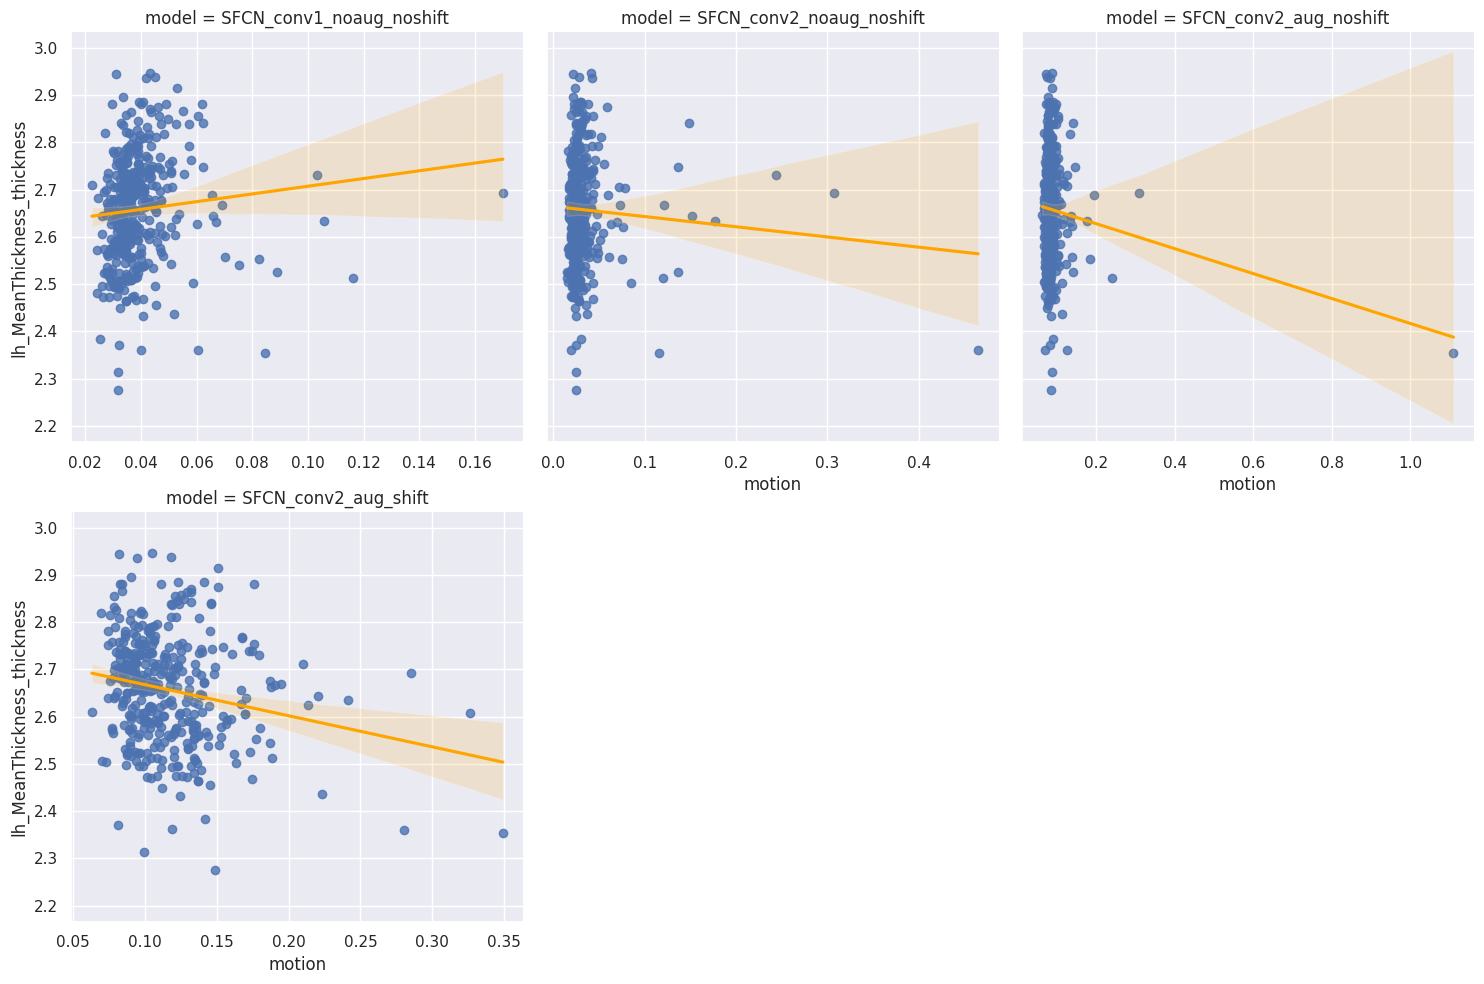

In [23]:
all = []
for m in models:
    all.append(get_cortical_hcpep_df(m))
hcpep_df = pd.concat(all)
sb.lmplot(
    hcpep_df,
    x="motion",
    y="lh_MeanThickness_thickness",
    line_kws={"color": "orange"},
    col="model",
    sharex=False,
    col_wrap=3,
)
len(hcpep_df.groupby(["sub", "ses"]).nunique()), len(hcpep_df["sub"].unique())

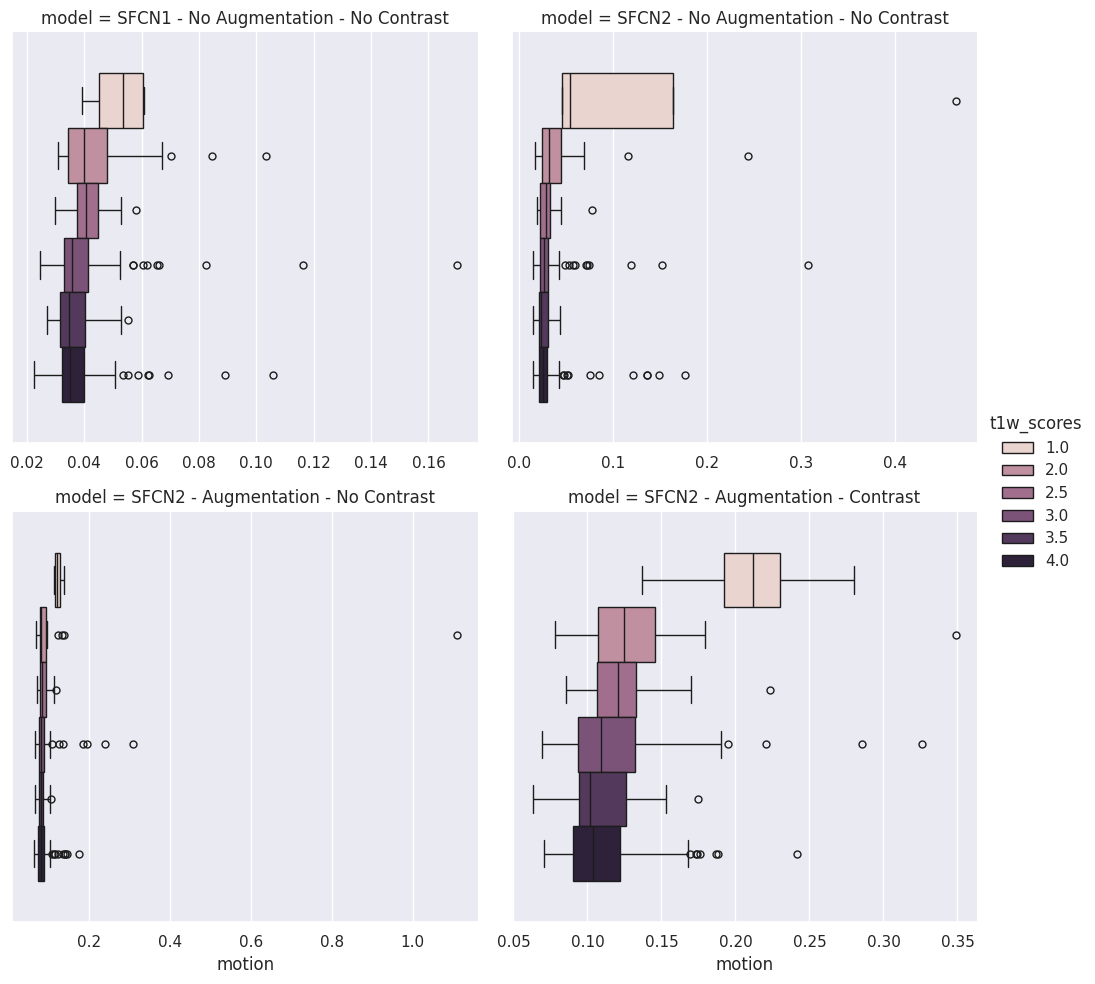

In [24]:
filt_hcpep_df = hcpep_df[hcpep_df["t1w_scores"].notna()].copy()
filt_hcpep_df["model"] = filt_hcpep_df["model"].apply(
    lambda x: "No ".join(
        x.replace("_conv", "").removesuffix("_noweight").replace("_", " - ").split("no")
    )
    .replace("aug", "Augmentation")
    .replace("shift", "Contrast")
)
sb.catplot(
    filt_hcpep_df,
    x="motion",
    hue="t1w_scores",
    col="model",
    kind="box",
    sharex=False,
    sharey=True,
    col_wrap=2,
)

In [26]:
fit_one_per_model(hcpep_df)

PatsyError: Error evaluating factor: NameError: name 'age' is not defined
    lh_MeanThickness_thickness ~ age + sex + motion
                                 ^^^

### OpenNeuro

/opt/anaconda/envs/bowl/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


(0.0, 0.6)

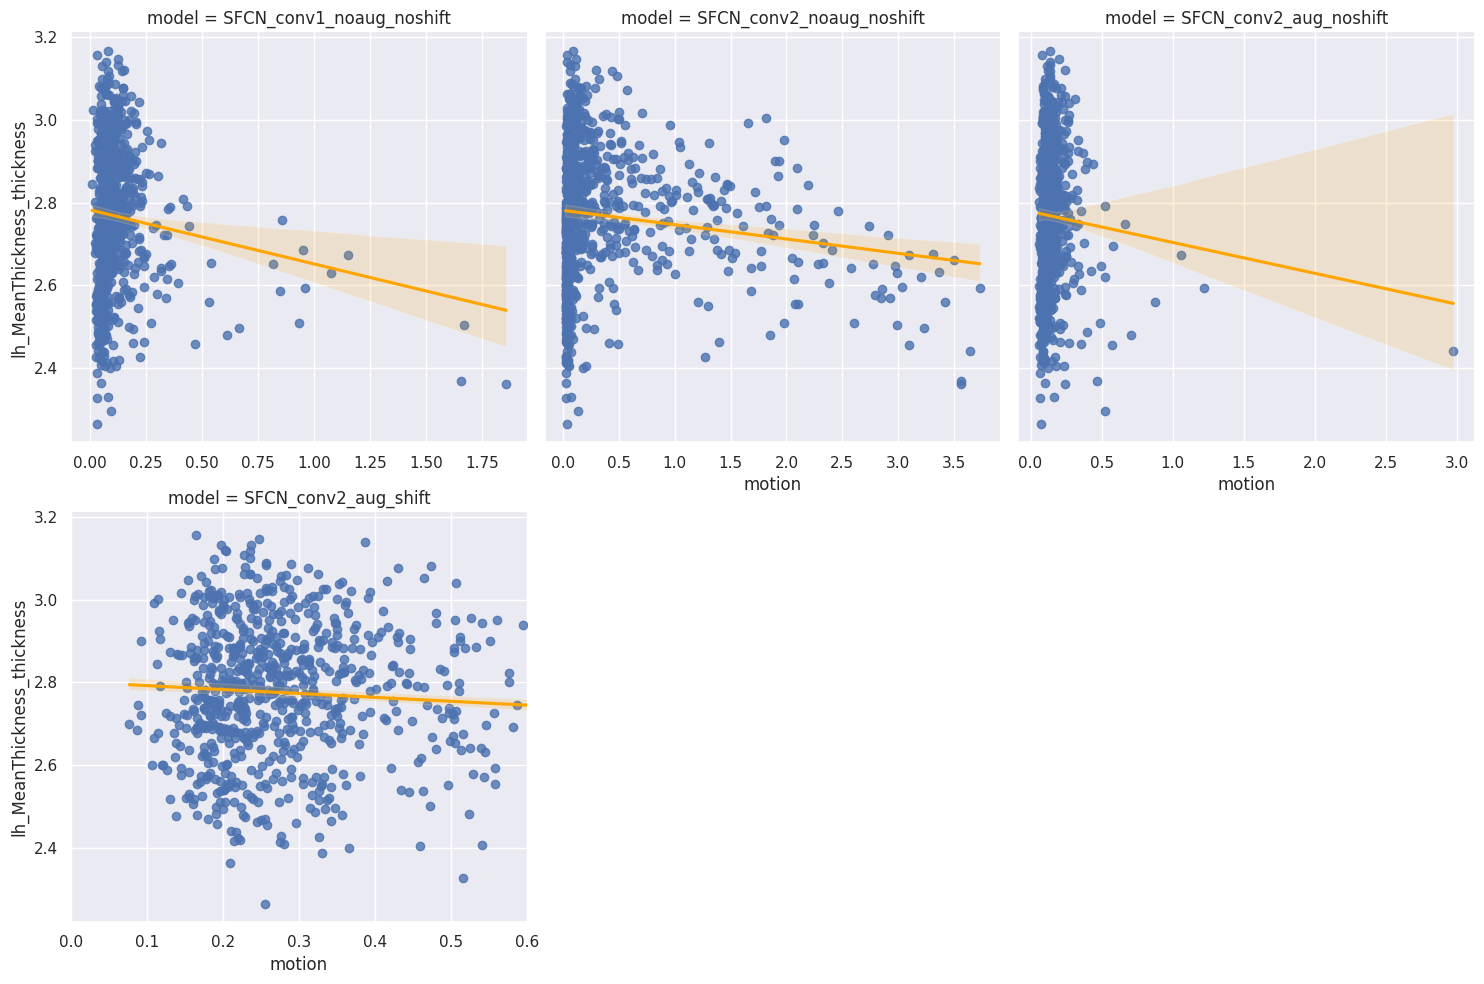

In [29]:
all = []
for m in models:
    all.append(get_all_openneuro(m))
openneuro_df = pd.concat(all)
sb.lmplot(
    openneuro_df,
    x="motion",
    y="lh_MeanThickness_thickness",
    line_kws={"color": "orange"},
    col="model",
    sharex=False,
    col_wrap=3,
)
plt.xlim((0, 0.6))

In [30]:
fit_openneuro = fit_one_per_model_per_dataset_openneuro(openneuro_df)
fit_openneuro["significant"] = fit_openneuro["pvalue"] < 0.05
pval = fit_openneuro.groupby("model")["pvalue"].agg(["mean"])
sign = fit_openneuro.groupby("model")["significant"].agg(["sum"])
motion = fit_openneuro.groupby("model")["motion"].agg(["mean"])
print(openneuro_df["dataset"].unique().shape)
pd.concat([pval, sign, motion], axis=1)

(11,)


,mean,sum,mean
model,,,
SFCN_conv1_noaug_noshift,0.262108,6,-0.202410
SFCN_conv2_aug_noshift,0.140159,7,-0.429214
SFCN_conv2_aug_shift,0.102741,8,-0.183761
SFCN_conv2_noaug_noshift,0.131555,7,-0.142465


In [35]:
best_model_openneuro = fit_openneuro[fit_openneuro["model"] == "SFCN_conv2_aug_shift"]
best_model_openneuro["adjusted_pvalue"] = false_discovery_control(
    best_model_openneuro["pvalue"]
)
best_model_openneuro["significant"] = best_model_openneuro["adjusted_pvalue"] < 0.05
(
    best_model_openneuro[best_model_openneuro["significant"]]["motion"].mean(),
    best_model_openneuro[best_model_openneuro["significant"]]["motion"].std(),
)

/tmp/ipykernel_1771056/4259233902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_model_openneuro["adjusted_pvalue"] = false_discovery_control(
/tmp/ipykernel_1771056/4259233902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_model_openneuro["significant"] = best_model_openneuro["adjusted_pvalue"] < 0.05


(-0.20787030881896978, 0.08781167191906725)

In [36]:
df = best_model_openneuro.copy().sort_values("dataset")

# Format individual columns as strings
df["motion"] = df["motion"].map(lambda x: f"{x:.2f}")
df["pvalue"] = df["pvalue"].map(lambda x: f"{x:.2e}")
df["adjusted_pvalue"] = df["adjusted_pvalue"].map(lambda x: f"{x:.2e}")
df["log_likelihood"] = df["log_likelihood"].map(lambda x: f"{x:.2f}")

# Now convert to LaTeX without using float_format
latex_table = df[
    ["dataset", "motion", "pvalue", "adjusted_pvalue", "log_likelihood"]
].to_latex(index=False, escape=False)

print(latex_table)

\begin{tabular}{lllll}
\toprule
dataset & motion & pvalue & adjusted_pvalue & log_likelihood \\
\midrule
ds000115 & -0.23 & 1.98e-04 & 3.63e-04 & 88.04 \\
ds000144 & -0.30 & 3.72e-07 & 1.36e-06 & 45.59 \\
ds000256 & -0.17 & 8.56e-05 & 1.88e-04 & 20.06 \\
ds001486 & -0.10 & 3.42e-07 & 1.36e-06 & 138.28 \\
ds001748 & -0.07 & 2.57e-01 & 2.83e-01 & 48.78 \\
ds002424 & -0.21 & 5.46e-07 & 1.50e-06 & 66.08 \\
ds002862 & -0.23 & 3.64e-03 & 5.71e-03 & 57.56 \\
ds002886 & -0.08 & 1.66e-02 & 2.28e-02 & 37.34 \\
ds003499 & 0.08 & 6.80e-01 & 6.80e-01 & 81.61 \\
ds003568 & -0.37 & 1.73e-01 & 2.11e-01 & 44.54 \\
ds005234 & -0.33 & 2.63e-11 & 2.90e-10 & 60.98 \\
\bottomrule
\end{tabular}



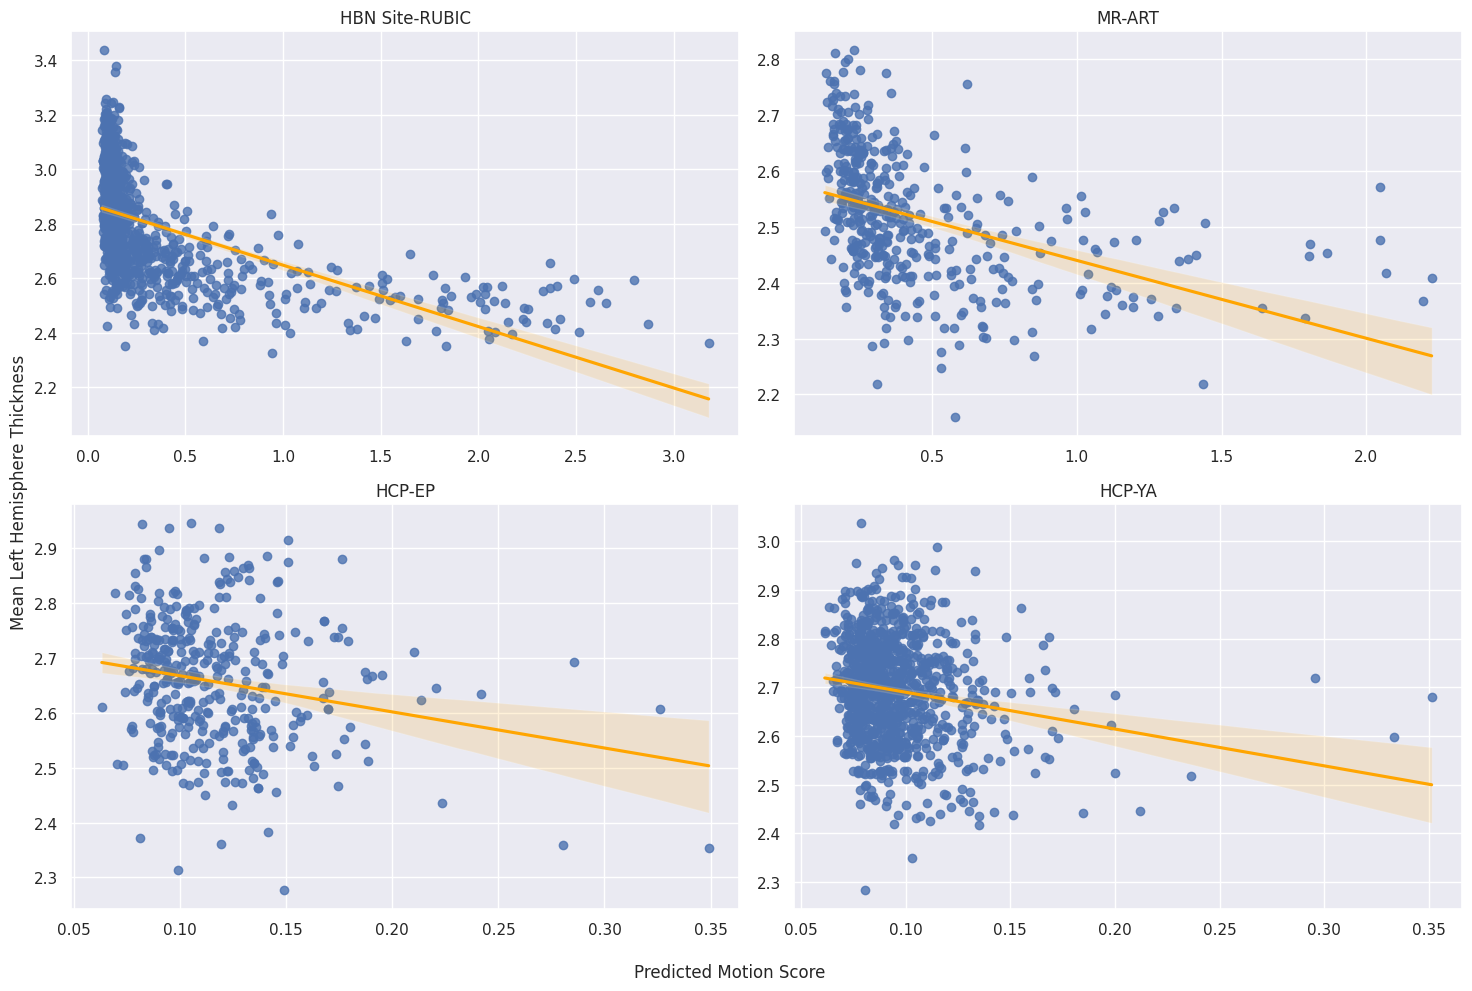

In [38]:
import matplotlib.pyplot as plt
import seaborn as sb

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Independent scales

axes = axes.flatten()

datasets = [
    ("HBN Site-RUBIC", hbnru_df),
    ("MR-ART", mrart_df),
    ("HCP-EP", hcpep_df),
    ("HCP-YA", hcpya_df),
]

for ax, (title, df) in zip(axes, datasets):
    sb.regplot(
        data=df[df["model"] == "SFCN_conv2_aug_shift"],
        x="motion",
        y="lh_MeanThickness_thickness",
        line_kws={"color": "orange"},
        ax=ax,
    )
    ax.set_title(title)
    ax.set_xlabel("")  # Remove individual x labels
    ax.set_ylabel("")  # Remove individual y labels

# Set shared axis labels
fig.supxlabel("Predicted Motion Score", fontsize=12)
fig.supylabel("Mean Left Hemisphere Thickness", fontsize=12)

plt.tight_layout()
plt.savefig("article/figures/regression_4_datasets.png")
plt.show()

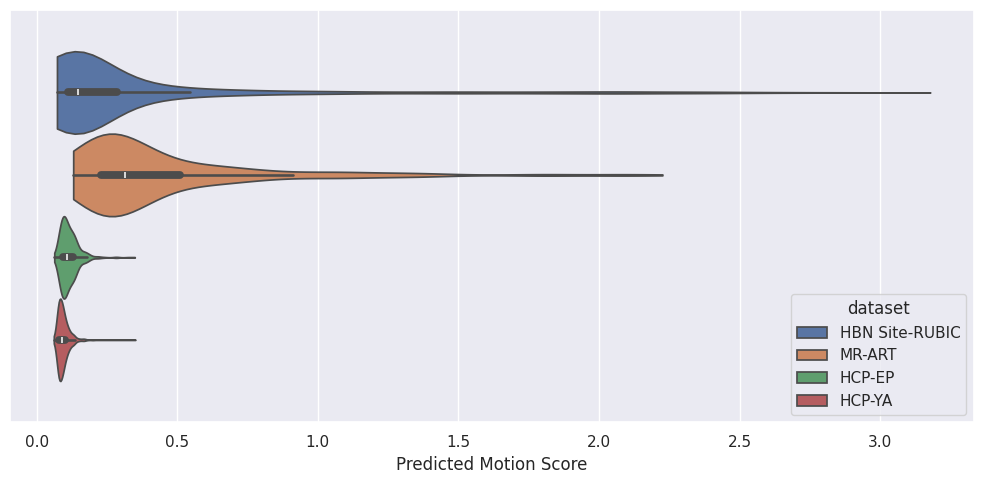

In [39]:
hcpep_df["dataset"] = "HCP-EP"
mrart_df["dataset"] = "MR-ART"
hcpya_df["dataset"] = "HCP-YA"
hbnru_df["dataset"] = "HBN Site-RUBIC"
full_df = pd.concat(
    [
        hcpep_df[["dataset", "motion", "model"]],
        mrart_df[["dataset", "motion", "model"]],
        hcpya_df[["dataset", "motion", "model"]],
        hbnru_df[["dataset", "motion", "model"]],
    ]
)

plt.figure(figsize=(10, 5))
sb.violinplot(
    full_df[full_df["model"] == "SFCN_conv2_aug_shift"],
    x="motion",
    hue="dataset",
    cut=0,
    hue_order=["HBN Site-RUBIC", "MR-ART", "HCP-EP", "HCP-YA"],
)
plt.xlabel("Predicted Motion Score", fontsize=12)


plt.tight_layout()
plt.savefig("article/figures/distribution_4_datasets.png")
plt.show()

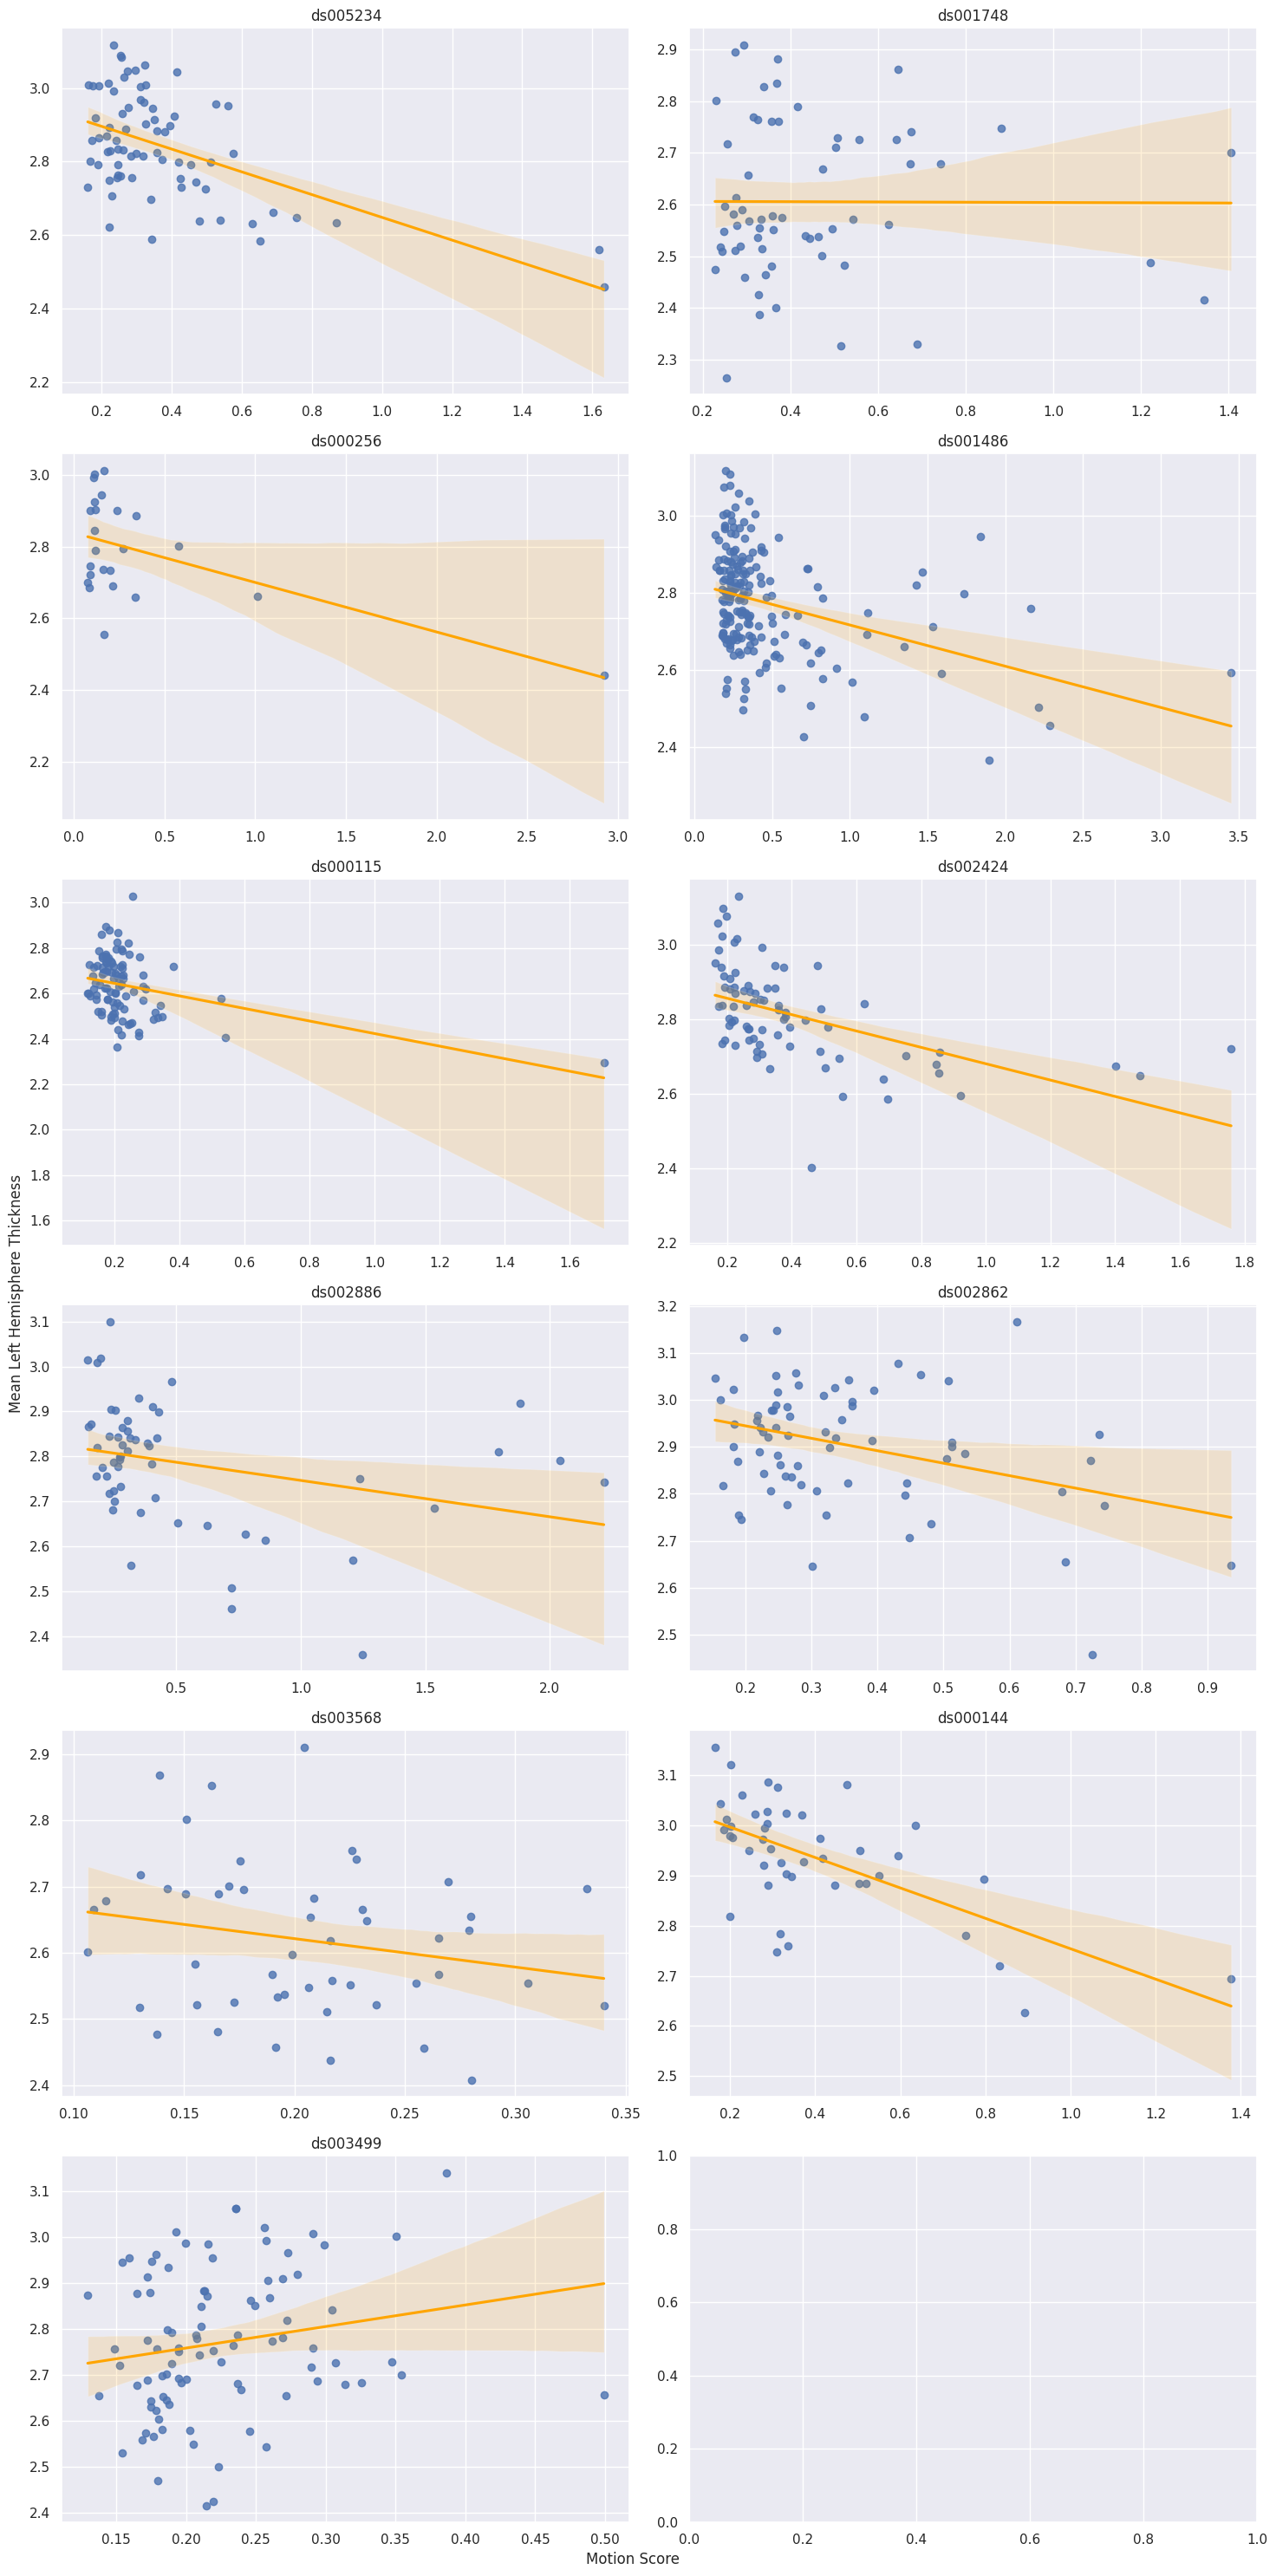

In [40]:
import matplotlib.pyplot as plt
import seaborn as sb

fig, axes = plt.subplots(6, 2, figsize=(15, 30))  # Independent scales

axes = axes.flatten()

datasets = openneuro_df["dataset"].unique()

for ax, ds in zip(axes, datasets):
    sb.regplot(
        data=openneuro_df[
            (openneuro_df["model"] == "SFCN_conv2_aug_shift")
            & (openneuro_df["dataset"] == ds)
        ],
        x="motion",
        y="lh_MeanThickness_thickness",
        line_kws={"color": "orange"},
        ax=ax,
    )
    ax.set_title(ds)
    ax.set_xlabel("")  # Remove individual x labels
    ax.set_ylabel("")  # Remove individual y labels

# Set shared axis labels
fig.supxlabel("Motion Score", fontsize=12)
fig.supylabel("Mean Left Hemisphere Thickness", fontsize=12)

plt.tight_layout()
plt.show()

## Age test

In [41]:
age_hcpya_df = hcpya_df.copy()
age_hcpya_df["age"] = age_hcpya_df["age"].apply(lambda x: int(x[:2]))
all = []
for ds, df in [
    ("HBN Site-RUBIC", hbnru_df),
    ("MR-ART", mrart_df),
    ("All Openneuro data", openneuro_df),
]:
    df_model = df[df["model"] == "SFCN_conv2_aug_shift"]
    est = smf.glm("motion ~ age ", data=df_model).fit()
    all.append({"ds": ds, "pvalue": est.pvalues["age"], "age": est.params["age"]})
age_df = pd.DataFrame(all)
age_df["corrected_pvalue"] = false_discovery_control(age_df["pvalue"])

df = age_df.copy()

# Format individual columns as strings
df["age"] = df["age"].map(lambda x: f"{x:.3f}")
df["pvalue"] = df["pvalue"].map(lambda x: f"{x:.2e}")
df["corrected_pvalue"] = df["corrected_pvalue"].map(lambda x: f"{x:.2e}")

# Now convert to LaTeX without using float_format
latex_table = df[["ds", "age", "pvalue", "corrected_pvalue"]].to_latex(
    index=False, escape=False
)

print(latex_table)

\begin{tabular}{llll}
\toprule
ds & age & pvalue & corrected_pvalue \\
\midrule
HBN Site-RUBIC & -0.022 & 9.78e-08 & 2.93e-07 \\
MR-ART & 0.004 & 1.86e-03 & 1.86e-03 \\
All Openneuro data & -0.010 & 1.14e-06 & 1.71e-06 \\
\bottomrule
\end{tabular}



In [ ]:
all = []
for ds, df in [
    ("HBN Site-RUBIC", hbnru_df),
    ("MR-ART", mrart_df),
    ("HCP-YA", hcpya_df),
]:
    model_df = df[df["model"] == "SFCN_conv2_aug_shift"]
    for c in df.columns:
        if "lh" in c and "thickness" in c:
            est = smf.glm(f"{c} ~ age +sex+motion", data=model_df).fit()
            all.append(
                {
                    "dataset": ds,
                    "pvalue": est.pvalues["motion"],
                    "motion": est.params["motion"],
                    "structure": c.removeprefix("lh_").removesuffix("_thickness"),
                }
            )

model_openneuro_df = openneuro_df[openneuro_df["model"] == "SFCN_conv2_aug_shift"]
for ds in model_openneuro_df["dataset"].unique():
    ds_df = model_openneuro_df[model_openneuro_df["dataset"] == ds]
    for c in ds_df.columns:
        if "lh" in c and "thickness" in c:
            est = smf.glm(f"{c} ~ age +sex+motion", data=ds_df).fit()
            all.append(
                {
                    "dataset": ds,
                    "pvalue": est.pvalues["motion"],
                    "motion": est.params["motion"],
                    "structure": c.removeprefix("lh_").removesuffix("_thickness"),
                }
            )

thick_df = pd.DataFrame(all)
thick_df["corrected_pvalue"] = false_discovery_control(thick_df["pvalue"])

thick_df["significant"] = thick_df["corrected_pvalue"] < 0.05
agg_thick = thick_df.groupby("dataset", as_index=False)["significant"].agg(
    ("sum", "count")
)
agg_thick["ratio_significant_structure"] = agg_thick["sum"] / agg_thick["count"] * 100
meanthick = thick_df[thick_df["structure"] == "MeanThickness"]
final_thick = agg_thick.merge(
    meanthick[["dataset", "significant", "pvalue", "corrected_pvalue", "motion"]],
    on="dataset",
)
# agg_thick, meanthick
final_thick["motion"] = final_thick["motion"].map(lambda x: f"{x:.3f}")
final_thick["pvalue"] = final_thick["pvalue"].map(lambda x: f"{x:.2e}")
final_thick["corrected_pvalue"] = final_thick["corrected_pvalue"].map(
    lambda x: f"{x:.2e}"
)
final_thick["ratio_significant_structure"] = final_thick[
    "ratio_significant_structure"
].map(lambda x: f"{x:.2f}%")

# Now convert to LaTeX without using float_format
latex_table = final_thick[
    ["dataset", "motion", "pvalue", "corrected_pvalue", "ratio_significant_structure"]
].to_latex(index=False, escape=True)
print(latex_table)

\begin{tabular}{lllll}
\toprule
dataset & motion & pvalue & corrected\_pvalue & ratio\_significant\_structure \\
\midrule
HBN Site-RUBIC & -0.246 & 1.55e-143 & 1.90e-141 & 97.14\% \\
HCP-YA & -0.651 & 2.73e-07 & 1.63e-06 & 77.14\% \\
MR-ART & -0.124 & 1.19e-21 & 1.46e-20 & 85.71\% \\
ds000115 & -0.232 & 1.98e-04 & 7.03e-04 & 54.29\% \\
ds000144 & -0.301 & 3.72e-07 & 2.17e-06 & 51.43\% \\
ds000256 & -0.173 & 8.56e-05 & 3.41e-04 & 54.29\% \\
ds001486 & -0.100 & 3.42e-07 & 2.02e-06 & 77.14\% \\
ds001748 & -0.068 & 2.57e-01 & 3.44e-01 & 17.14\% \\
ds002424 & -0.213 & 5.46e-07 & 3.01e-06 & 74.29\% \\
ds002862 & -0.229 & 3.64e-03 & 9.00e-03 & 40.00\% \\
ds002886 & -0.082 & 1.66e-02 & 3.45e-02 & 17.14\% \\
ds003499 & 0.075 & 6.80e-01 & 7.42e-01 & 2.86\% \\
ds003568 & -0.366 & 1.73e-01 & 2.47e-01 & 11.43\% \\
ds005234 & -0.332 & 2.63e-11 & 2.35e-10 & 68.57\% \\
\bottomrule
\end{tabular}

